# **Базовая оптимизация**

В базовой оптимизации, предоставляемой библиотекой **sklearn**, есть два основных метода — **grid search** и **random search**. С ними мы сейчас и познакомимся. Оба используются при решении реальных задач, поэтому важно разобраться, как они устроены. 
***
Наиболее часто используемый метод — это **поиск по сетке** (**grid search**), который по сути является попыткой *перебрать все возможные комбинации заданных гиперпараметров*. Мы указываем список значений для различных гиперпараметров, и, ориентируясь на нашу метрику, оцениваем эффективность модели для каждого их сочетания, чтобы получить оптимальную комбинацию значений.

Допустим, мы хотим подобрать гиперпараметры min_samples_leaf и max_depth для алгоритма DecisionTreeClassifier. Зададим списки их значений:

In [1]:
min_samples_leaf = [3, 5, 8, 9]
max_depth = [4, 5, 6, 7, 8]

Поскольку нам нужно перебрать четыре различных значения для min_samples_leaf и пять — для max_depth, то получается всего 4*5=20 комбинаций. Модель будет обучена 20 раз; столько же раз будет рассчитана метрика.

Сетка выглядит следующим образом:

![](data/f1.PNG)

***
## **ОПАСНОСТЬ ПЕРЕОБУЧЕНИЯ И УТЕЧКИ ДАННЫХ**

Для того, чтобы выбрать оптимальные значения гиперпараметров, мы ориентируемся на выбранную метрику, рассчитанную на тестовой выборке. Мы делали это для подбора гиперпараметра регуляризации alpha, но является ли это надёжным подходом?

Эту проблему мы уже обсуждали в модуле ML-5 «Валидация и оценка качества моделей».

Давайте вспомним: *мы перебираем множество значений гиперпараметров и выбираем ту комбинацию значений, которая даёт наилучшую точность на тестовых данных*.

                 Однако это совсем не означает, что на новых данных мы получим такой же результат. 

Поскольку мы использовали тестовый набор для настройки гиперпараметров, мы больше не можем использовать его для оценки качества модели. Теперь в этих целях нам необходим независимый набор данных, то есть набор, который не использовался для построения модели и настройки её гиперпараметров.

Следовательно, надо разбить данные на три части: **обучающую** для построения модели, **проверочную (валидационную)** для выбора гиперпараметров модели, а также **тестовую** для оценки качества модели и выбранных гиперпараметров. 

![](https://lms.skillfactory.ru/assets/courseware/v1/0c708e747f9ffedab3acaf873b0c5577/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-3.png)

Наличие всех трёх наборов данных критически важно для использования МО. Любой подбор гиперпараметров, сделанный на тестовых данных, «сливает» модели информацию, содержащуюся в них, и может привести к неправильной оценке качества модели. Такая проблема относится к категории утечки данных, которую мы уже тоже затрагивали в модуле по валидации.

***Рассмотренный метод разбиения данных на обучающий, проверочный и тестовый наборы является вполне рабочим и относительно широко используемым, но весьма чувствительным к равномерности разбиения данных.***
***

Для лучшей оценки обобщающей способности вместо одного разбиения данных на обучающий и проверочный наборы мы можем воспользоваться перекрёстной проверкой, то есть **кросс-валидацией (cross validation)**. В таком случае качество модели оценивается для каждой комбинации гиперпараметров по всем разбиениям кросс-валидации.

![](https://lms.skillfactory.ru/assets/courseware/v1/761310cd7523c307072cadd085cf577e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-4.png)

**Пояснение к рисунку.** Предположим, что у нас есть ***n*** комбинаций гиперпараметров. Берём первую комбинацию и обучаем на них первую модель с помощью кросс-валидации с 10 фолдами (cv=10), затем рассчитываем метрику как среднее по всем разбиениям. Так проделываем для каждой комбинации и выбираем ту, при которой наша метрика наилучшая. В итоге мы обучим n*cv моделей, но выберем один набор гиперпараметров, который и будет использоваться для обучения итоговой модели на всей обучающей выборке.

***
## **GRIDSEARCHCV**

Поскольку поиск по сетке с кросс-валидацией является весьма распространённым методом настройки гиперпараметров, библиотека **scikit-learn** предлагает класс **GridSearchCV**, в котором осуществляется именно такой вариант.

✍️ Посмотрим, как это реализовано на практике.

Для этого продолжим решать задачу классификации из модуля ML-3 «Предсказываем категорию дохода человека», где вы изучали алгоритмы МО, а теперь проделаем оптимизацию гиперпараметров для каждого из них.
***
Описание данных

Данные, с которыми мы будем работать, были извлечены из базы данных Бюро переписи населения 1994 года Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной и заключалась в предсказании дохода. Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50 000 $.

Признаки:

* age — возраст
* workclass — сфера занятости
* fnlwgt — общий вес (число людей, которых, по мнению эксперта, представляет эта категория занятости)
* education — уровень образования
* education.num — образовательная ступень (в виде числа)
* marital.status — семейное положение
* occupation — род деятельности
* relationship — родственные отношения
* race — раса
* sex — пол
* capital.gain — ежегодный дополнительный прирост капитала
* capital.loss — ежегодная дополнительная потеря капитала
* hours.per.week — число рабочих часов в неделю
* native.country — страна рождения
* income — категория дохода (целевой признак — более 50К$ или менее 50К$)

### **Предобработка**

In [57]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV # класс GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # RandomizedSearchCV

%matplotlib inline
plt.style.use('seaborn')

In [31]:
data = pd.read_csv('data/adult.csv')

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


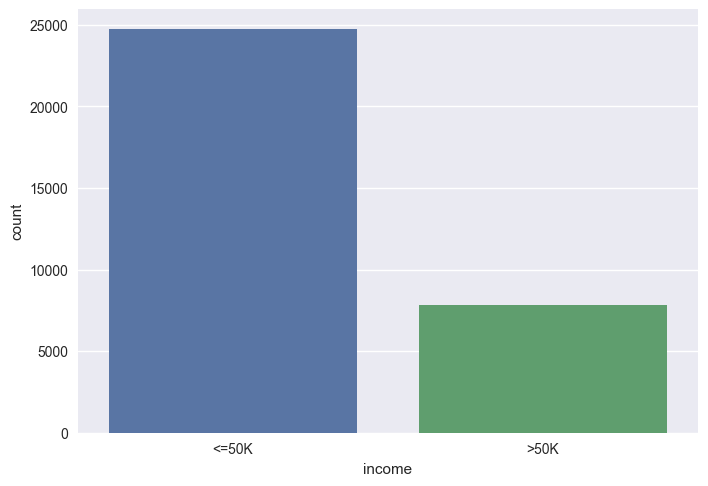

In [32]:
# Проверяем наличие пропусков
display(data.isnull().sum())
# Изучаем категориальные признаки
display(data.describe(include='object'))
# Смотрим на сбалансированность классов:
sns.countplot(data=data, x='income');

In [33]:
# переобозначим целевой признак (не обязательный шаг)
data['income'] = data['income'].apply(lambda x: 0 if x == '<=50K' else 1)

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

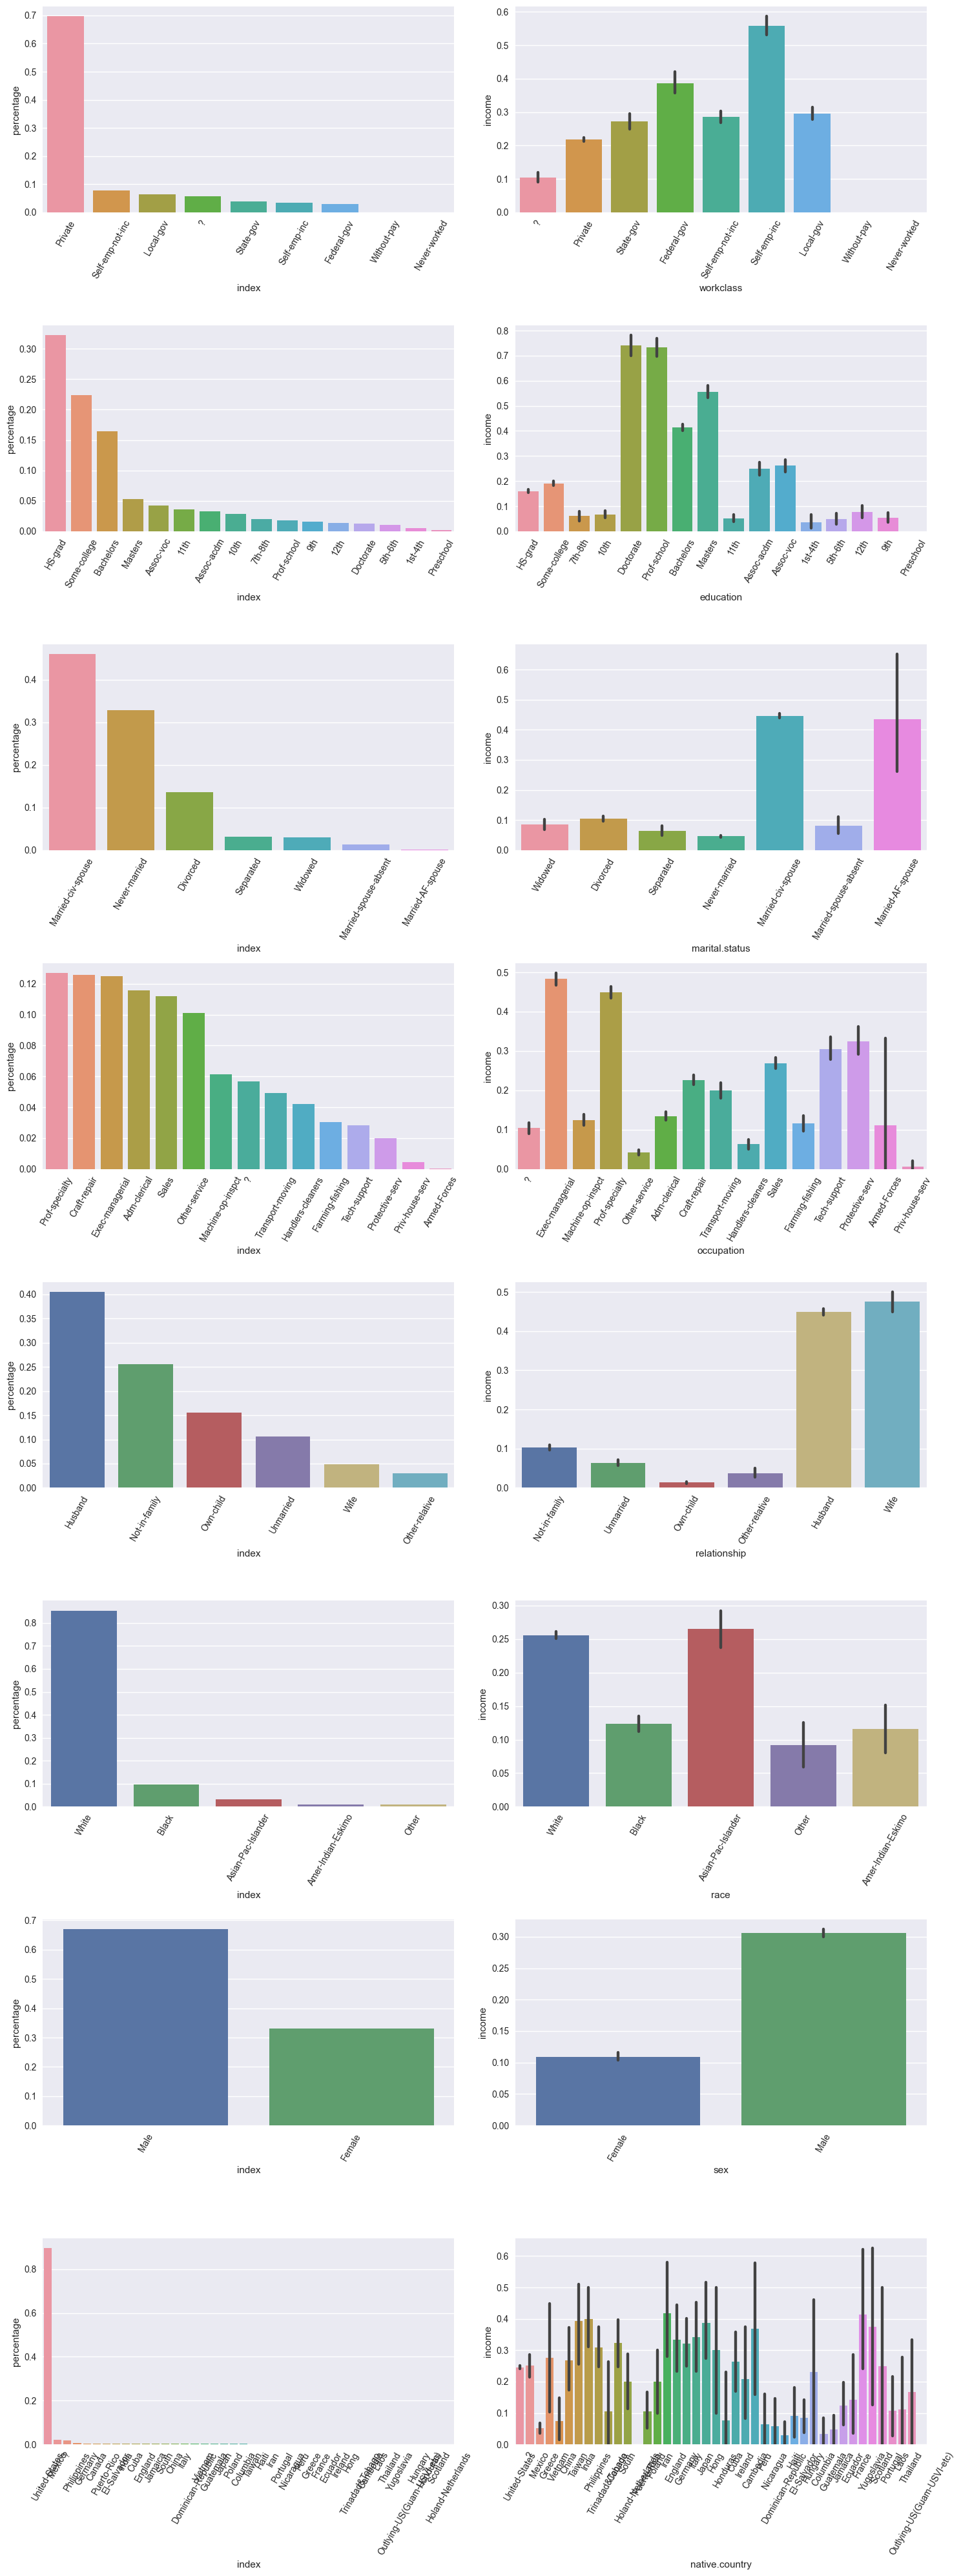

In [35]:
# Исследуем категориальные признаки
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
display(cat_features)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

In [36]:
# Предобрабатываем категориальные признаки: уменьшаем количество категорий



adult_data = data.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [37]:
# Предобрабатываем числовые признаки


#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [38]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

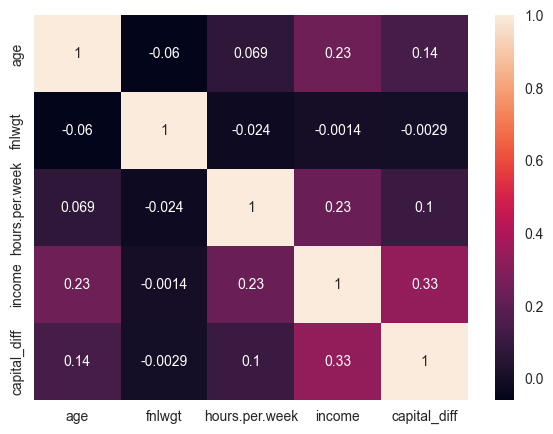

In [39]:
# Оцениваем мультиколинеарность и взаимосвязь с целевым признаком
plt.figure(figsize = (7, 5))
sns.heatmap(adult_data.corr(), annot = True);

In [40]:
# Кодируем текстовые категориальные признаки
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [41]:
# выгрузка для дальнейшей работы
dummies_data.to_csv("data/adult_new.csv")

### **Продолжение**

Зафиксируем только те метрики, которые были получены без дополнительной настройки, то есть со значениями гиперпараметров, установленных по умолчанию:

In [42]:
X = dummies_data.drop(['income'], axis=1)
y = dummies_data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [43]:
# Производим нормализацию данных с помощью min-max нормализации
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64


А теперь попробуем подобрать оптимальные параметры с помощью поиска по сетке. 

Основные параметры **GridSearchCV**:

* **estimator** — алгоритм, который будем оптимизировать;
* **param_grid** — словарь или список словарей. Словарь с именами гиперпараметров (в формате строки (str), например, 'max_depth') в качестве ключей и списками параметров (например, [5, 8, 10]) в качестве значений. Итого: {'max_depth': [5, 8, 10] }.
* **scoring** — по умолчанию используется score-функция заданного алгоритма:
  * для классификации — **sklearn.metrics.accuracy_score**;
  * для регрессии — **sklearn.metrics.r2_score**;  
    Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите [здесь](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
* **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
* **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.

In [ ]:
# Также можно передать список таких словарей:

#param_grid = [{'max_depth': [5, 8, 10],
#               'min_samples_leaf': [7, 8, 9] } #первый словарь 
#              {'n_estimators': [100, 200, 300], 
#               'max_depth': [5, 8, 10] }] #второй словарь 

В таком случае каждый словарь в списке перебирается отдельно и последовательно. Это позволяет выполнять поиск по любой последовательности настроек параметров.

Чтобы воспользоваться классом **GridSearchCV**, необходимо:

1. Импортировать библиотеку:

**from sklearn.model_selection import GridSearchCV**

2. Указать искомые гиперпараметры в виде словаря  param_grid: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров. Мы рассмотрим сетку из:

   * **'penalty'** — тип регуляризации. Может принимать значения l1,  l2, 'elasticnet' или None (отсутствие регуляризации);
   * **'solver'** — алгоритм оптимизации, может принимать значения 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', по умолчанию — 'lbfgs'.

Важно помнить, что выбор алгоритма оптимизации зависит от выбранного типа штрафа:

![](https://lms.skillfactory.ru/assets/courseware/v1/843b8646e16b0a034ea479809c4a8d5c/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-5.png)

In [46]:
param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
                  'solver': ['lbfgs', 'saga'] #алгоритм оптимизации
                  }

3. Вызвать класс **GridSearchCV** и передать модель (**LogisticRegression**), сетку искомых параметров (**param_grid**), а также число фолдов, которые мы хотим использовать в кросс-валидации, и **n_jobs** = -1, чтобы использовать все доступные ядра для расчётов:

In [47]:
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=1, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

4. Созданный нами объект grid_search аналогичен классификатору, поэтому мы можем вызвать стандартные методы **fit**, **predict** и **score** от его имени. Однако, когда мы вызываем fit(), он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid:

In [48]:
grid_search.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'saga']})

***GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всём обучающем наборе данных с использованием параметров, которые дают наилучшее значение метрики при кросс-валидации.***

Наилучшая найденная комбинация гиперпараметров сохраняется в атрибуте **best_params_**:

In [49]:
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

Наилучшие значения параметров: {'penalty': 'none', 'solver': 'lbfgs'}


Наилучшая метрика:

In [50]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.84


Либо можем посмотреть любую другую метрику, воспользовавшись методом **predict()** и передав предсказанные значения в функцию для расчёта метрики (например, **f1_score()**):

In [51]:
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.64


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это неудивительно, и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться!

Попробуем расширить сетку гиперпараметров и проделаем те же шаги:

In [52]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регуляризации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
 
# %time - замеряет время выполнения
%time grid_search_1.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))
y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 812 ms
Wall time: 1min 1s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l2', 'solver': 'lbfgs'}


Метрику опять не удалось улучшить, а времени потратили много, в пять раз больше!

Поиск по сетке не гарантирует, что мы найдём наилучшую комбинацию гиперпараметров. Всё потому, что сетка значений конечна, и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданных нами.

Итоговая модель хранится в параметре **best_estimator_**, ей можно воспользоваться для получения прогнозов на новых данных: 

In [53]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=1000, penalty='none', random_state=1)


А наилучшее значение метрики на кросс-валидации (значение метрики, усреднённое по всем разбиениям для данной комбинации гиперпараметров) хранится в атрибуте **best_score_**.

Примечание. Не путайте **best_score_** со значением метрики модели, которое вычисляется на тестовом наборе с помощью метода **score**. Метод **score** (оценивающий качество результатов, полученных с помощью метода **predict()**) использует модель, построенную на всём обучающем наборе данных. В атрибуте **best_score_** записывается средняя метрика на кросс-валидации.

In [54]:
print("Наилучшее значение точности при кросс-валидации: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидации: 0.84


Результаты кросс-валидации хранятся в параметре **cv_results_**. Отрисуем, как менялась метрика при различных гиперпараметрах:

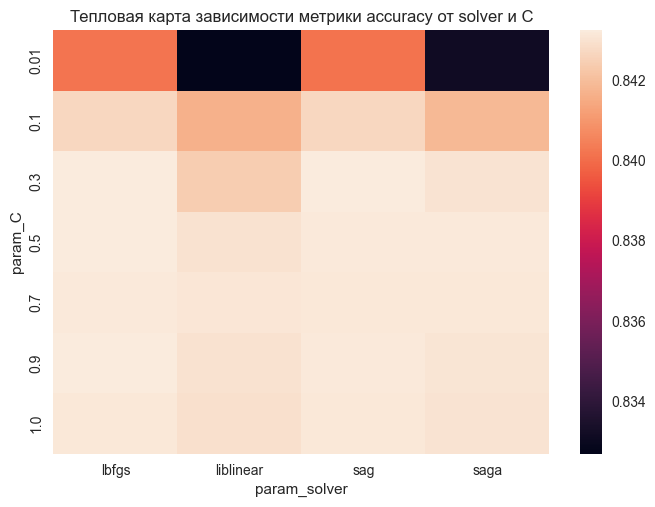

In [55]:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
               values='mean_test_score', index='param_C',
               columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0.01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0.5 и алгоритмы оптимизации **lbfgs** и **sag** работают лучше.

***
## **RANDOMIZEDSEARCHCV**

***Несмотря на то, что поиск по сетке — мощный метод для нахождения оптимального набора гиперпараметров, оценка всех возможных комбинаций требует множество времени и вычислительных ресурсов, а также кросс-валидации для обучения моделей.***

Альтернативным подходом подбора различных комбинаций гиперпараметров в библиотеке scikit-learn является **RandomizedSearchCV**. 

**Рандомизированный поиск** работает почти так же, как решётчатый поиск, но он гораздо экономичнее и эффективнее по времени, потому что мы *можем задать количество подбираемых комбинаций, а не брать все возможные*.

![](https://lms.skillfactory.ru/assets/courseware/v1/7bc80431d813a9af9a6ec0409c53c4df/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-7.png)

На этой картинке изображено принципиальное различие двух методов: 

* В **GridSearchCV** сетка задаётся *вручную*, перебираются различные значения гиперпараметров *с каким-то шагом*, в итоге получается что-то похожее на «красивую» сетку слева на картинке. Однако минимум функции (белое пятно) мы так и не обнаруживаем — а ведь он где-то рядом, возможно, просто между подобранными нами комбинациями.
* **RandomizedSearchCV** выбирает *n* (количество задаем сами) *случайных точек/комбинаций* из заданных нами последовательностей. Как следствие, мы можем перебирать не все возможные точки, а только часть из них, тем самым управляя скоростью работы перебора.

Основные параметры **RandomizedSearchCV** аналогичны **GridSearchCV**, за исключением **n_iter**:

* **estimator** — алгоритм, который будем оптимизировать;
* **param_distributions** — словарь или список словарей (param_grid - в старых версиях склёрна).
* **scoring** — по умолчанию используется score-функция заданного алгоритма:
  * для *классификации* — sklearn.metrics.accuracy_score;
  * для *регрессии* — sklearn.metrics.r2_score;
    Возможно выбрать любую другую в зависимости от условий задачи. Различные варианты смотрите [здесь](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
* **cv** — количество фолдов в кросс-валидации, по умолчанию используется 5.
* **n_jobs** — количество ядер для распараллеливания расчёта. -1 использует все существующие ядра.
* **n_iter** — количество комбинаций на расчёт. От этого параметра напрямую зависит время оптимизации и качество модели.

In [60]:
from sklearn.model_selection import RandomizedSearchCV
#np.linspace(start(от), stop(до), num=50(количество),dtype-тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
 
 
%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

c:\Users\Roman\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: total: 656 ms
Wall time: 29.6 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'none', 'C': 0.67}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку, проделаем то же с помощью GridSearchCV и сравним:

In [61]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10,       dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
  
%time grid_search_2.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test_scaled, y_test)))
y_test_pred = grid_search_2.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: total: 656 ms
Wall time: 1min 26s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.64
Наилучшие значения гиперпараметров: {'C': 3.34, 'penalty': 'l2', 'solver': 'lbfgs'}


На перебор всей сетки GridSearchCV понадобилось больше времени.

Проделаем аналогичное для **DecisionTreeClassifier()**. Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [62]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.62


Теперь зададим сетку гиперпараметров:

* 'min_samples_leaf' — минимальное количество объектов в листе;
* 'max_depth' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
* 'criterion' — критерий информативности.

И посчитаем **RandomizedSearchCV()** и **GridSearchCV()**.

In [64]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 875 ms
Wall time: 5.96 s
accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.65
Наилучшие значения гиперпараметров: {'min_samples_leaf': 39, 'max_depth': 13, 'criterion': 'gini'}


In [ ]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Метрику удалось улучшить с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени.
***
Проделаем аналогичное для **RandomForestClassifier**. Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [65]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.66


Теперь зададим сетку гиперпараметров:

* 'n_estimators' — количество деревьев в лесу, по умолчанию = 100;
* 'min_samples_leaf' — минимальное количество объектов в листе;
* 'max_depth' — максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение.

Посчитаем **RandomizedSearchCV()** и **GridSearchCV()**.

In [66]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 1.89 s
Wall time: 15.8 s
f1_score на обучающем наборе: 0.72
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.68
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 33}


In [67]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 1.8 s
Wall time: 26.6 s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 110}


На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV в сравнении с GridSearchCV.
***
***

Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте RandomizedSearchCV с параметрами cv = 5, n_iter = 10.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [68]:
param_distributions = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5,7],
              'max_depth': [10, 15, 20, 25]
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.44 s
Wall time: 15.9 s
f1_score на обучающем наборе: 0.70
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 160, 'min_samples_leaf': 7, 'max_depth': 25}


Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:

* n_estimators = от 100 до 200 с шагом 30
* min_samples_leaf = [5, 7]
* max_depth = [10, 15, 20, 25]

Используйте GridSearchCV с параметрами cv = 5.

В ответе укажите метрику f1 на тестовой выборке, значение округлите до двух знаков после запятой (например, 0.58).

In [69]:
param_grid = {'n_estimators': list(range(100, 200, 30)),
              'min_samples_leaf': [5,7],
              'max_depth': [10, 15, 20, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = grid_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test_scaled, y_test)))
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 2.02 s
Wall time: 48.9 s
f1_score на обучающем наборе: 0.71
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}


***
## **РЕКОМЕНДАЦИИ ПО НАСТРОЙКЕ ГИПЕРПАРАМЕТРОВ АНСАМБЛЕЙ НАД РЕШАЮЩИМИ ДЕРЕВЬЯМИ**

**АЛГОРИТМ СЛУЧАЙНОГО ЛЕСА (RANDOMFOREST)**

* **n_estimators** — число итераций (количество деревьев). Частично работает правило «чем больше, тем лучше», но иногда это не имеет особого смысла и сильно увеличивает затраты, поэтому стоит пробовать обучать сотни деревьев [100,200, 300, 400]. Если нет изменений, то оставить минимальное — 100.
* **max_depth** — максимальная глубина дерева. В случайном лесе строятся «сильные» деревья, каждое из которых даёт полноценный прогноз, поэтому глубина деревьев может быть достаточно большой. Стоит следить за переобучением.
* **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения;
*  **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма — дерева.

**АЛГОРИТМ ГРАДИЕНТНОГО БУСТИНГА (GRADIENTBOOSTING)**

                        Примечание. Так как алгоритм градиентного бустинга мы ещё не проходили,
                        вы можете вернуться в данный раздел, когда изучите модуль ML-8.

* **n_estimators** — число итераций (количество деревьев): хотя ошибка на обучении монотонно стремится к нулю, ошибка на контроле, как правило, начинает увеличиваться после определенной итерации. Оптимальное число итераций можно выбирать, например, по отложенной выборке или с помощью кросс-валидации.
* **learning_rate** — темп обучения (0;1]:  
    На практике оказывается, что градиентный бустинг очень быстро строит композицию, ошибка которой на обучении выходит на асимптоту (достигает предела), после чего начинает настраиваться на шум и переобучаться. Параметр learning_rate контролирует, насколько сильно каждое дерево будет пытаться исправить ошибки предыдущих деревьев. Более высокая скорость обучения означает, что каждое дерево может внести более сильные корректировки. Как правило, чем меньше темп обучения, тем лучше качество итоговой композиции.

* **max_depth** — максимальная глубина дерева. Используется для борьбы с переобучением. Рекомендуется устанавливать не более 5.
* **max_features** — максимальное количество признаков, учитываемых алгоритмом при поиске лучшего разделения.
* **subsample** — доля выборки, которая будет использоваться для обучения каждого алгоритма. Это ещё один способ улучшения качества градиентного бустинга. Таким образом вносится рандомизация в процесс обучения базовых алгоритмов, что снижает уровень шума в обучении, а также повышает эффективность вычислений. 

*Рекомендация. Берите подвыборки, размер которых вдвое меньше исходной выборки.*

![](https://lms.skillfactory.ru/assets/courseware/v1/45b02502c5c4e40efe50955501850e7b/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-8.png)


Главное отличие техник **Bagging** и **Boosting** состоит в параллельном и последовательном построении деревьев соответственно.

Основные параметры градиентного бустинга деревьев — это количество деревьев (**n_estimators**) и скорость обучения (**learning_rate**), контролирующие степень вклада каждого дерева в устранение ошибок предыдущих деревьев. Эти два параметра тесно взаимосвязаны, поскольку более низкое значение **learning_rate** означает, что для построения модели аналогичной сложности необходимо большее количество деревьев.

*В отличие от случайного леса, в котором более высокое значение **n_estimators** всегда дает лучшее качество, увеличение значения **n_estimators** в градиентном бустинге даёт более сложную модель, что может привести к переобучению. При всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, способные сформировать полноценный прогноз.*

Общепринятая практика для бустинга — подгонять n_estimators в зависимости от бюджета времени и памяти, а затем подбирать различные значения learning_rate.

Подробнее о градиентном бустинге можно почитать по [ссылке](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html). 